In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

# 优化、运行随机森林模型和回测

In [75]:
location =  "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/"
file = "j9000_d.csv"
exported_signal_file = "j9000_d_testing_signals.csv"
n = 10
test_size = 1/6

In [359]:
def preprocess_df(location, file):
    df = pd.read_csv(location+file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df

def rebalance(unbalanced_data, rblnc_rs):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    if unbalanced_data.target.value_counts()[0]>unbalanced_data.target.value_counts()[1]:
        print ("majority:0, length: {}; minority:1, length: {}".format(unbalanced_data.target.value_counts()[0],unbalanced_data.target.value_counts()[1]))
        data_minority = unbalanced_data[unbalanced_data.target==1] 
        data_majority = unbalanced_data[unbalanced_data.target==0] 
    else:
        print ("majority:1, length: {}; minority:0, length: {}".format(unbalanced_data.target.value_counts()[1],unbalanced_data.target.value_counts()[0]))
        data_minority = unbalanced_data[unbalanced_data.target==0] 
        data_majority = unbalanced_data[unbalanced_data.target==1] 
    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=rblnc_rs)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled.target.value_counts()
    return data_upsampled

def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    
    
def train_test_validate(master_df, train_start, train_end, test_size, tts_rs, rblnc_rs, plot=True): 
    # train_start example: '2011-01-01'
    # test_size defaults as 1/6, 
    # test_size: parameter
    
    data = master_df.copy()
    data.index = pd.to_datetime(data.index)
    if plot == True:
        print ("Plotting data's close price series")
        ax = data[['close']].plot(figsize=(20, 5))
        ax.set_ylabel("Price (￥)")
        ax.set_xlabel("Time")
        plt.show()
    else:
        pass
    data_train = data[train_start : train_end]
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    data_train = rebalance(data_train, rblnc_rs).dropna()
    # y as the label target 
    y = data_train.target
    # X as the dataframe with their values to be normalized
    X = data_train.drop('target', axis=1)
    X = normalize(X)
    
    data_val = data[train_end:]
    data_val.dropna(inplace=True)
    # y_val as the label target in the validation period
    y_val = data_val.target
    # X_val as the dataframe with their values to be normalized in the validation period
    X_val = data_val.drop('target', axis=1)
    # normalize X_val dataframe
    X_val = normalize(X_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = tts_rs)
    print ("-----------------------------------------------")
    print ("X length: ", len(X))
    print ("X_val length: ", len(X_val))
    print ("X_train length: ", len(X_train))
    print ("X_test length: ", len(X_test))
    print ("-----------------------------------------------")
    print ("y length: ", len(y))
    print ("y_val length: ", len(y_val))
    print ("y_train length:", len(y_train))
    print ("y_test length:", len(y_test))
    print ("-----------------------------------------------")
    # Outputs of this function are 8 variables from above.
    return data, X, X_val, X_train, X_test, y, y_val, y_train, y_test
    
    
def optimize_model_paras(X_train, y_train, X_test, y_test):
    # first take a look at the default model's results:
    model = RandomForestClassifier(random_state=5)
    print ("Training default model...")
    model.fit(X_train, y_train)
    print ("Default model's scores:")
    scores(model, X_test, y_test)
    # set up parameters to be optimized
    grid_data =   {'n_estimators': [10, 50, 100],
                   'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 10, 50, 100],
                   'min_samples_split': [2, 5, 10],
                   'random_state': [1]}
    grid = GridSearchCV(model, grid_data, scoring='f1').fit(X_train, y_train)
    print ("-----------------------------------------------")
    print ("Model's best parameters: ")
    print(grid.best_params_)
    model = grid.best_estimator_
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Performance of the train_test datasets: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("Optimized Model from the train_test dataset: ", model)
    
    # Validate optimized model:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    optimized_model = model
    return optimized_model

def train_test_backtest(data, optimized_model, X, y, X_train, y_train, start_capital):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("train_test datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum() + start_capital
    equity = model_returns.sum()
    start_close = data["close"][X.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns (￥)")
    ax.set_xlabel("Time")
    plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns


# Trading system: testing real performance:
def validate_backtest(data, optimized_model, X_val, y_val, X_train, y_train, start_capital):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("validation datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()+start_capital
    equity = model_returns.sum()
    start_close = data["close"][X_val.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns ($)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()
#     print (pd.DataFrame(model_cum)) # 对了
    return model_cum, equity, performance, mask, y_pred, data_returns, acc

# Create signal file that is to be imported to TB:
def create_TB_signal_df(df, X_val, y_pred, y_val, mask, data_returns, exported_file):
    print ("Processing signal dataframe...")
    master_pred_df = X_val.copy()
    master_pred_df['y_pred'] = y_pred
    master_pred_df['y_val'] = y_val
    master_pred_df['mask'] = mask
    master_pred_df['data_returns'] = data_returns
    master_pred_df['model_returns'] = mask * data_returns
    master_pred_df_dt = master_pred_df.copy()
    master_pred_df_dt.reset_index(inplace = True)
    
    print ("Processing original OHLCV dataframe...")
    df_dt = df.copy()
    del df_dt['date']
    df_dt.reset_index(inplace= True)
    df_dt['date'] = pd.to_datetime(df_dt['date'])

    print ("Merging signal dataframe and OHLCV dataframe...")
    master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
    merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
    merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
    
    print ("Exporting final signal file...")
#     merged.to_csv(location + exported_file, index = False, header = False)
    print ("All done!")
    
    return merged, master_pred_df

In [357]:
data

,sma,ema,momentum,rsi,macd,close,target
date,,,,,,,
2011-04-15,NaN,2250.000000,NaN,NaN,0.000000,2250.0,1
2011-04-18,NaN,2319.142857,NaN,NaN,0.660655,2382.0,0
2011-04-19,NaN,2325.670695,NaN,NaN,0.278644,2337.0,1
2011-04-20,NaN,2330.927386,NaN,NaN,0.195790,2344.0,0
2011-04-21,NaN,2332.143880,NaN,NaN,0.030983,2336.0,0
2011-04-22,NaN,2331.905113,NaN,NaN,-0.133889,2331.0,0
2011-04-25,NaN,2331.736099,NaN,NaN,-0.223768,2331.0,0
2011-04-26,NaN,2330.247436,NaN,NaN,-0.407824,2323.0,0
2011-04-27,NaN,2328.945537,NaN,NaN,-0.529068,2322.0,1


Plotting data's close price series


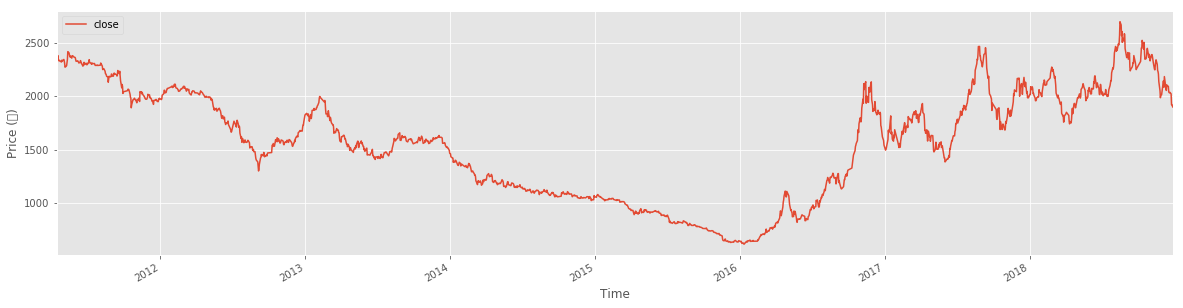

majority:0, length: 756; minority:1, length: 636
-----------------------------------------------
X length:  1500
X_val length:  487
X_train length:  1250
X_test length:  250
-----------------------------------------------
y length:  1500
y_val length:  487
y_train length: 1250
y_test length: 250
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
# Part 1:
df = preprocess_df(location, file)

# Part 2:
master_df = get_data(df, n)

# Part 3:
data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, '2011-01-01','2017-01-01', test_size, 1, True)

In [78]:
# Part 4: unnecessary function to run if we already have all optimized parameters
# optimized_model = optimize_model_paras(X_train, y_train, X_test, y_test)

In [79]:
# Part 4: if we already have all optimized parameters we just run this step: 
optmzd_model = RandomForestClassifier(
            bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False
            )

train_test datasets performance: 
Accuracy Score: 95.87 %
F1 Score: 0.9593
Area Under ROC Curve Score: 0.9586
----------------------------------------------------


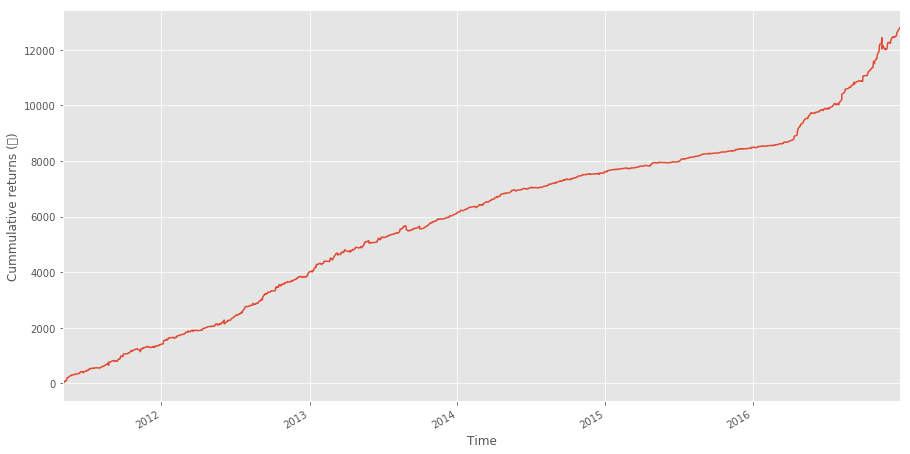

In [80]:
# Part 5: See in-sample backtest
model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(optmzd_model, X, y, X_train, y_train)

validation datasets performance: 
Accuracy Score: 53.80 %
F1 Score: 0.4804
Area Under ROC Curve Score: 0.5419
----------------------------------------------------


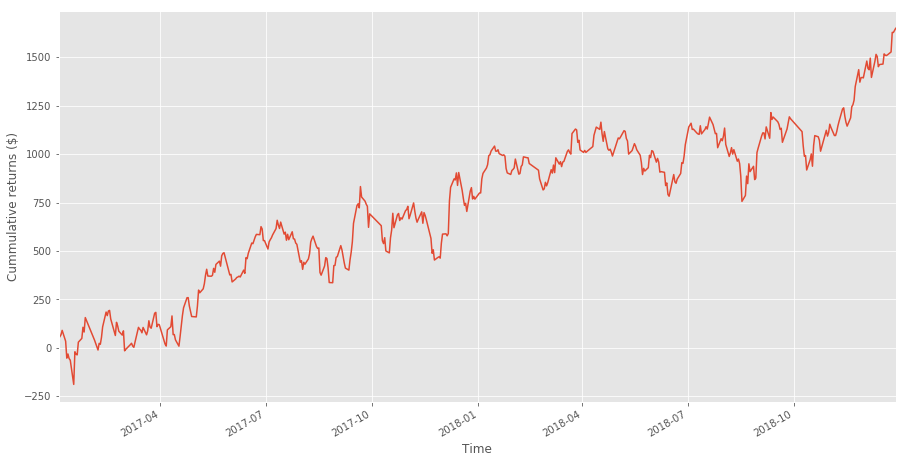

In [177]:
# Part 6: See out-of-sample backtest
model_cum_, equity_, performance_, mask_, y_pred_, data_returns_ = validate_backtest(optmzd_model, X_val, y_val, X_train, y_train)

In [82]:
# Part 7: Merge OHLCV dataframe and signal dataframe:

merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, exported_signal_file)

Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!


# 随机森林参数调节注意事项

https://www.cnblogs.com/pinard/p/6160412.html

## scikit-learn随机森林类库概述

RF需要调参的参数也包括两部分，第一部分是Bagging框架的参数，第二部分是CART决策树的参数。下面我们就对这些参数做一个介绍。

## RF框架参数

1) **n_estimators** : 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，计算量会太大，并且n_estimators到一定的数量后，再增大n_estimators获得的模型提升会很小，所以一般选择一个适中的数值。默认是**100**。

2) **oob_score** :即是否采用袋外样本来评估模型的好坏。默认识False。个人推荐设置为**True**，因为袋外分数反应了一个模型拟合后的泛化能力。

3) **criterion**: 即CART树做划分时对特征的评价标准。分类模型和回归模型的损失函数是不一样的。分类RF对应的CART分类树默认是**基尼系数gini**,另一个可选择的标准是信息增益('entropy')。回归RF对应的CART回归树默认是均方差mse，另一个可以选择的标准是绝对值差mae。一般来说选择默认的标准就已经很好的。

从上面可以看出， RF重要的框架参数比较少，主要需要关注的是 n_estimators，即RF最大的决策树个数。

## RF决策树参数

**1)** RF划分时考虑的最大特征数**max_features**: 可以使用很多种类型的值，默认是"auto",意味着划分时最多考虑根号N个特征；如果是"log2"意味着划分时最多考虑log2N个特征；如果是"sqrt"或者"auto"意味着划分时最多考虑根号N个特征。如果是整数，代表考虑的特征绝对数。如果是浮点数，代表考虑特征百分比，即考虑（百分比xN）取整后的特征数。其中N为样本总特征数。一般我们用默认的**"auto"**就可以了，如果特征数非常多，我们可以灵活使用刚才描述的其他取值来控制划分时考虑的最大特征数，以控制决策树的生成时间。

**2)** 决策树最大深度**max_depth**: 默认可以不输入，如果不输入的话，决策树在建立子树的时候不会限制子树的深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值**10-100**之间。

**3)** 内部节点再划分所需最小样本数**min_samples_split**: 这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 **默认是2**.如果样本量不大，不需要管这个值。**如果样本量数量级非常大，则推荐增大这个值**。

**4)** 叶子节点最少样本数**min_samples_leaf**: 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。**默认是1**,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。**如果样本量数量级非常大，则推荐增大这个值**。

**5)** 叶子节点最小的样本权重和**min_weight_fraction_leaf**：这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。 **默认是0，就是不考虑权重问题**。一般来说，**如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重**，这时我们就要注意这个值了。

**6)** 最大叶子节点数**max_leaf_nodes**: **通过限制最大叶子节点数，可以防止过拟合，默认是"None”**，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。**如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制**，具体的值可以通过交叉验证得到。

**7)** 节点划分最小不纯度**min_impurity_split**:  这个值限制了决策树的增长，如果某节点的不纯度(基于基尼系数，均方差)小于这个阈值，则该节点不再生成子节点。即为叶子节点 。**一般不推荐改动默认值1e-7**。

上面决策树参数中最重要的包括最大特征数**max_features**， **最大深度max_depth**， 内部节点再划分所需最小样本数**min_samples_split**和叶子节点最少样本数**min_samples_leaf**。

majority:0, length: 756; minority:1, length: 636
-----------------------------------------------
X length:  1500
X_val length:  487
X_train length:  1250
X_test length:  250
-----------------------------------------------
y length:  1500
y_val length:  487
y_train length: 1250
y_test length: 250
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 95.67 %
F1 Score: 0.9572
Area Under ROC Curve Score: 0.9567
----------------------------------------------------


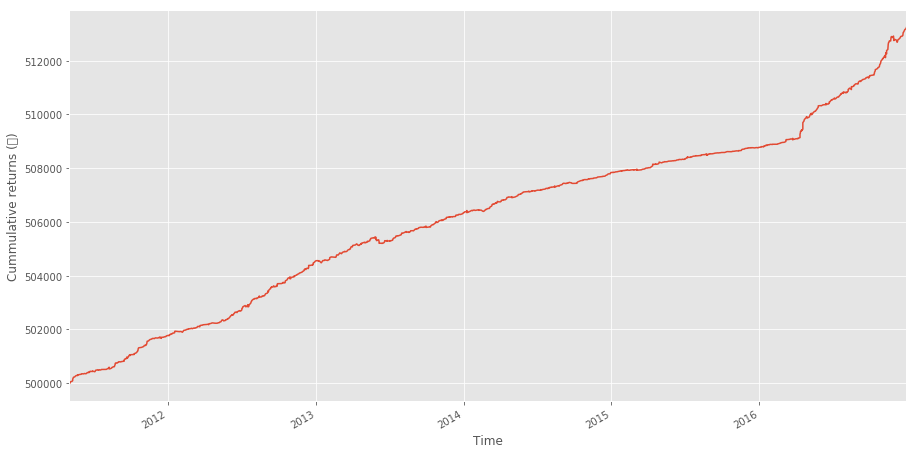

validation datasets performance: 
Accuracy Score: 54.83 %
F1 Score: 0.5238
Area Under ROC Curve Score: 0.5504
----------------------------------------------------


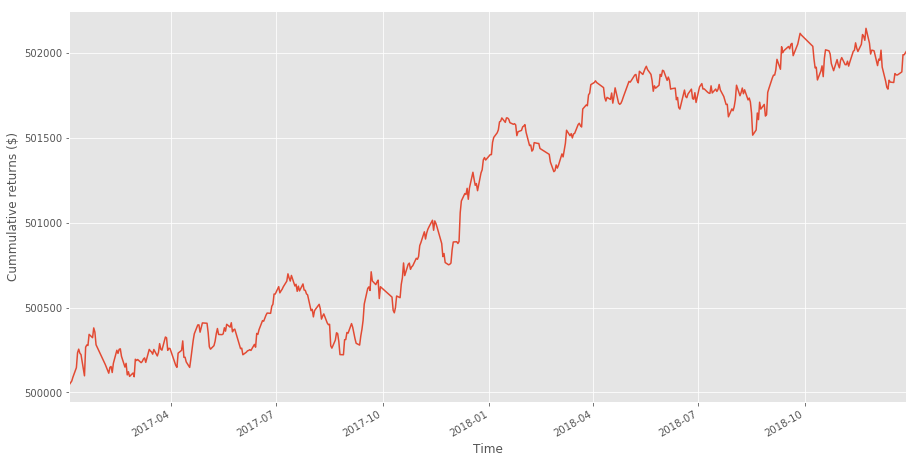

=============================================All Finished.==================================================
   RFC_rs  accuracy  backtest  rblnc_rs    sharpe  trades  tts_rs
0       1  0.548255         1         1  1.404121     122       1


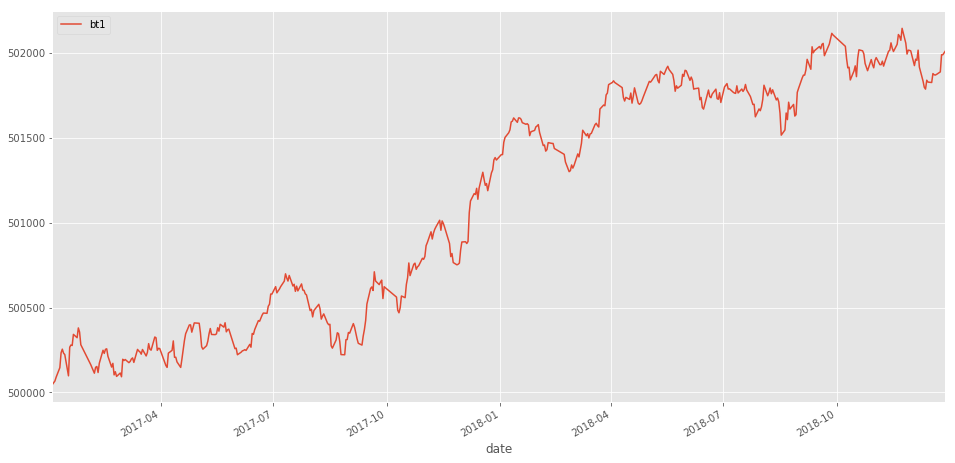

In [360]:
rblnc_rs = [1]
tts_rs = [1]
RFC_rs = [1]
start_capital = 500000
trade_freq = 1

backtest_records = {'backtest':[],
                    'rblnc_rs':[],
                    'tts_rs':[],
                    'RFC_rs':[],
                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}

def RF_rs_loop_AIO(rblnc_rs, tts_rs, RFC_rs, start_capital):

    # Part 1:
    df = preprocess_df(location, file)

    # Part 2:
    master_df = get_data(df, n)

    # Part 3:
    data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, '2011-01-01','2017-01-01', test_size, tts_rs, rblnc_rs, False)

    # Part 4: if we already have all optimized parameters we just run this step: 
    optmzd_model = RandomForestClassifier(
                bootstrap=True, class_weight=None, criterion='entropy',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=RFC_rs, verbose=0, warm_start=False
                )

    # Part 5: See in-sample backtest
    model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(data, optmzd_model, X, y, X_train, y_train, start_capital)

    # Part 6: See out-of-sample backtest
    model_cum_, equity_, performance_, mask_, y_pred_, data_returns_, acc_ = validate_backtest(data, optmzd_model, X_val, y_val, X_train, y_train, start_capital)
#     print (pd.DataFrame(model_cum_))  # 已解决
    return model_cum_, y_pred_, acc_
    

backtest_num = 0
backtest_curves = pd.DataFrame([])
total_backtests = len(rblnc_rs)*len(tts_rs)*len(RFC_rs)
for rs_1 in rblnc_rs:
    for rs_2 in tts_rs:
        for rs_3 in RFC_rs:
            model_cum_, y_pred_, acc_ = RF_rs_loop_AIO(rs_1, rs_2, rs_3, start_capital)
            backtest_num = backtest_num + 1
            returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
            returns_mean = returns.mean() 
            returns_stddev = returns.std()
            sharpe = returns_mean/returns_stddev*np.sqrt(252)
            signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
            signals_df['trades'] = signals_df.diff()
            num_of_trades = len(signals_df[signals_df['trades']!=0])
            
#             print ("backtest: ", backtest_num)
#             print ("rblnc_rs: ", rs_1)
#             print ("tts_rs: ", rs_2)
#             print ("RFC_rs: ", rs_3)
#             print ("sharpe: ", sharpe)
#             print ("trades: ", num_of_trades)
#             print ("accuracy: ", acc_)
            backtest_records['backtest'].append(backtest_num)
            backtest_records['rblnc_rs'].append(rs_1)
            backtest_records['tts_rs'].append(rs_2)
            backtest_records['RFC_rs'].append(rs_3)
            backtest_records['sharpe'].append(sharpe)
            backtest_records['trades'].append(num_of_trades)
            backtest_records['accuracy'].append(acc_)
            print ("=============================================All Finished.==================================================")
#             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
            backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
            
new_cols = []
for col_num in range(1, total_backtests+1):
    new_col = "bt{}".format(col_num)
    new_cols.append(new_col)
backtest_curves.columns = new_cols

backtest_curves.plot(figsize=(16, 8))
df_bt = pd.DataFrame(backtest_records)
print (df_bt)

In [318]:
backtest_curves['combined'] = backtest_curves['bt1']+backtest_curves['bt2']+backtest_curves['bt3']+backtest_curves['bt4']+\
                                backtest_curves['bt5']+backtest_curves['bt6']+backtest_curves['bt7']+backtest_curves['bt8']

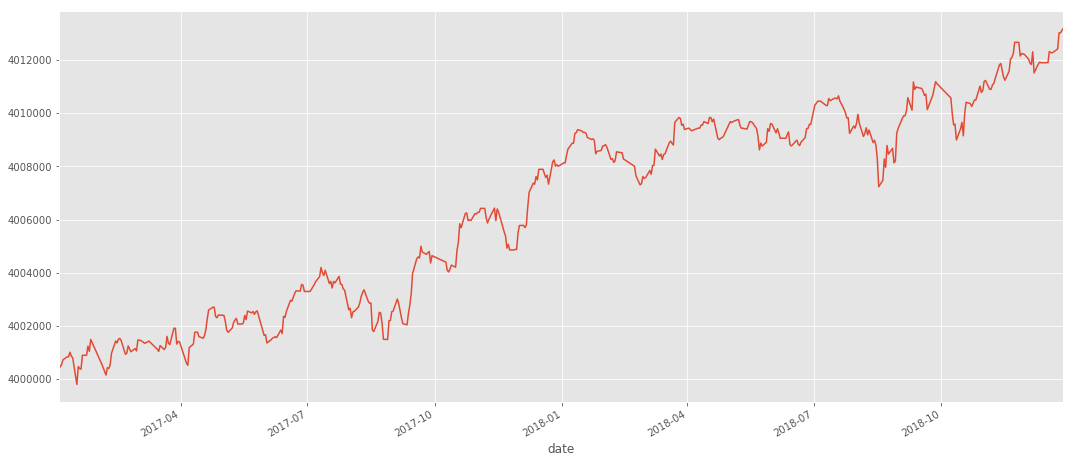

In [323]:
backtest_curves['combined'].plot(figsize = (18, 8))

In [330]:
len(model_cum_)

487

In [349]:
signals_df

,signals,trades
date,,
2017-01-03,1,NaN
2017-01-04,1,0.0
2017-01-05,1,0.0
2017-01-06,1,0.0
2017-01-09,1,0.0
2017-01-10,0,-1.0
2017-01-11,1,1.0
2017-01-12,0,-1.0
2017-01-13,0,0.0


In [348]:
num_of_trades

124

# 计算加入交易次数

In [326]:
model_cum_

date
2017-01-03    500047.5
2017-01-04    500057.5
2017-01-05    500067.5
2017-01-06    500090.0
2017-01-09    500146.0
2017-01-10    500233.5
2017-01-11    500255.0
2017-01-12    500278.5
2017-01-13    500270.0
2017-01-16    500145.0
2017-01-17    500313.5
2017-01-18    500300.5
2017-01-19    500297.5
2017-01-20    500363.0
2017-01-23    500382.5
2017-01-24    500325.0
2017-01-25    500300.5
2017-01-26    500375.0
2017-02-03    500258.5
2017-02-06    500207.5
2017-02-07    500242.0
2017-02-08    500237.0
2017-02-09    500272.5
2017-02-10    500327.0
2017-02-13    500403.5
2017-02-14    500422.0
2017-02-15    500398.0
2017-02-16    500401.0
2017-02-17    500445.0
2017-02-20    500381.5
                ...   
2018-11-19    500990.0
2018-11-20    501047.5
2018-11-21    501058.0
2018-11-22    501081.5
2018-11-23    501152.0
2018-11-26    501239.0
2018-11-27    501174.5
2018-11-28    501151.5
2018-11-29    501150.0
2018-11-30    501147.5
2018-12-03    501060.5
2018-12-04    501022.5
2018-1